# Sales Success Prediction

We are interested in developing a robust machine learning system that leverages information coming from call center data. Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

### Data Description:

The data comes from direct marketing campaign that involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.


Attributes:

- age : age of customer (numeric)
- job : type of job (categorical)
- marital : marital status (categorical)
- education (categorical)
- default: has credit in default? (binary)
- balance: average yearly balance, in euros (numeric)
- housing: has a housing loan? (binary)
- loan: has personal loan? (binary)
- contact: contact communication type (categorical)
- day: last contact day of the month (numeric)
- month: last contact month of year (categorical)
- duration: last contact duration, in seconds (numeric)
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

Output (desired target):
- y - has the client subscribed to a term deposit? (binary)

## Objectives:
Predict if the customer will subscribe (yes/no) to a term deposit (variable y)

### Success Metric:
Hit %81 or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.
   
   


#### Importing Libraries

In [1]:
# Import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# # Import lazypredict package
# import lazypredict
# from lazypredict.Supervised import LazyClassifier

# Import label encoding and scaling from preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Import dataset split and kfold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

# Import metrics packages of sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Import classifier models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Import sklearn tree graphing package
from sklearn.tree import export_graphviz

#### Loading the data

In [2]:
# Load dataset
df = pd.read_csv('datasets/term-deposit-marketing-2020.csv')

# Inspect Dataframe
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


#### Exploring the data
From the overview of the dataframe above, it is clear that dataset has some combination of categorical data and numeric data. Now I will explore the data to see if there is any missing data or if the data we have makes sense. Also it is necessary to know  if some columns are intercorrelated. And which data will be available to us in real life, so we can make a decision to call.

In [3]:
# Print DataFrame information
df.info()

print('\n')

# Print summary statistics
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB




,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


There is no NaN data in dataset to imputation is not necessary. From summary of statistics of dataset, median age of the customer is 39 years. They have average yearly bvalance ranging from -8019 euros to 102000 euros, with IQR 54 to 1319 euros. Number of contacts performed during this campaign and for this client has IQR 1 to 3. While some clients receiving up to 63 calls.

#### Inspect existing numerical data
In theory, duration of call can be indicative if sale was successful. Sales representative will talk longer to the customer that is buying to explain terms of agreement or answer any other questions. To see if there is any direct correlation between duration of call and result of sale I build a box plot of duration of call and result of sale.

(0.0, 2000.0)

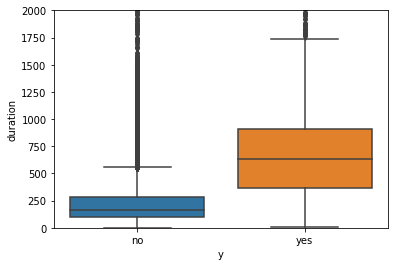

In [4]:
# Build box plot of duration of call in vertical axis
sns.boxplot(x = 'y', y = 'duration', data = df)

# Set y limit for a plot
plt.ylim(0,2000)

It is clear from result that there is direct correlation between sales result and duration of call. As in real life we won't have length of call in our dataset, we drop it from our dataset.  
Another interesting parameter to test is a campaign column, which indicates number of contacts performed during this campaign for this client. As it might be indicative and helping models, due to the fact that more contacts might mean success.

(0.0, 10.0)

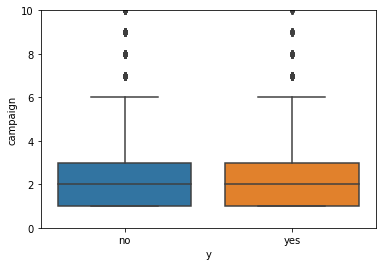

In [5]:
# Build box plot of number of calls in vertical axis
sns.boxplot(x = 'y', y = 'campaign', data = df)

# Set y limit for a plot
plt.ylim(0,10)

Boxplots of effect of number of contacts performed during campaign indicate that there is no clear correlation with sales success indicator. With same number of contacts it is possible to get any kind of result. Probability of success does not directly depend on number of calls. Except for extremely high number of contacts ~40. So you should stop calling once you contacted 40 times. As there are no records indicating any sale was successful once contacted over 40 times. 

#### Inspect categorical data

First of all, it is necessary to find which columns have categorical data and unique values in them. Knowing these values, it will be possible to check if there are any inconsistencies in dataset.

In [6]:
# Create a function that finds all categorical columns, and put all unique values in the columns into dataframe
def chk_categoricals(df):
    cols = []
    uniq_vals = []
    for col in df.columns:
        if df[col].dtypes == 'object':
            cols.append(col)
            uniq_vals.append(df[col].unique())
    uv_df = pd.DataFrame(uniq_vals, index = cols)
    return(uv_df)

# Run the function to check categorical columns
chk_categoricals(df).head(20)

,0,1,2,3,4,5,6,7,8,9,10,11
job,management,technician,entrepreneur,blue-collar,unknown,retired,admin,services,self-employed,unemployed,housemaid,student
marital,married,single,divorced,None,None,None,None,None,None,None,None,None
education,tertiary,secondary,unknown,primary,None,None,None,None,None,None,None,None
default,no,yes,None,None,None,None,None,None,None,None,None,None
housing,yes,no,None,None,None,None,None,None,None,None,None,None
loan,no,yes,None,None,None,None,None,None,None,None,None,None
contact,unknown,cellular,telephone,None,None,None,None,None,None,None,None,None
month,may,jun,jul,aug,oct,nov,dec,jan,feb,mar,apr,None
y,no,yes,None,None,None,None,None,None,None,None,None,None


#### Handling the categorical data
These categorical datasets can be divided into three groups, based on their values.
* First group consists of binary columns, those that have only yes or no options:
    - default
    - housing
    - loan
    - y - success (has the client subscribed to a term deposit)
* Second group contains columns, that are non binary and categories in which can be sorted based on values:
    - education
    - month
* And the third group consists of data that are also non binary and can not be sorted:
    - job
    - marital status
    - contact

As dataset contains both months and days of last contact, I decided to investigate the effect of doy of the week on success of sales. For this reason I added a new column, a weekday when last contact was made.

<AxesSubplot:xlabel='y', ylabel='weekday'>

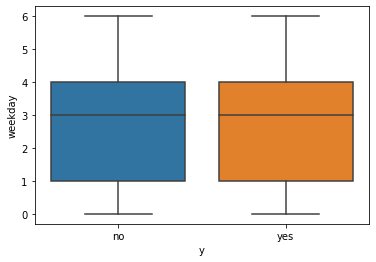

In [7]:
# Create dictionary with months values. Replacement of month column data
d_m = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
df['month'].replace(d_m, inplace = True)

# Create week day columnn in dataframe
df['weekday'] = pd.to_datetime('2020/' + df['month'].astype('str') + '/' + df['day'].astype('str')).dt.dayofweek

# Build box plot of day of a week
sns.boxplot(x = 'y', y = 'weekday', data = df)

From built boxplot chart, there is no dependance of success of sale to week day

## Base Model - using label encoder
In this work I will try three scenarios based on converting of categorical data to numerical:
1. Base Model - just use label encoder
2. Sorted labeling - I sort categorical data based on their impact
3. One hot method - convert categorical data to numeric using one hot labels

#### Preprocessing the data

Now it is time to convert categorical data to numeric data. Scikit learn's label encoder is used for this task.

In [8]:
# Create label encoder
le = LabelEncoder()

# Iterate through columns to do numeric transformation if dtype is categorical
for col in df.columns:
  if df[col].dtypes == 'object':
    df[col] = le.fit_transform(df[col])

# Inspect data   
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y,weekday
0,58,4,1,2,0,2143,1,0,2,5,5,261,1,0,1
1,44,9,2,1,0,29,1,0,2,5,5,151,1,0,1
2,33,2,1,1,0,2,1,1,2,5,5,76,1,0,1
3,47,1,1,3,0,1506,1,0,2,5,5,92,1,0,1
4,33,11,2,3,0,1,0,0,2,5,5,198,1,0,1


Since all of the data in dataset is in numeric format, correlation heatmap can be build. It will allow to identify if there is any correlation that can affect results.

<AxesSubplot:>

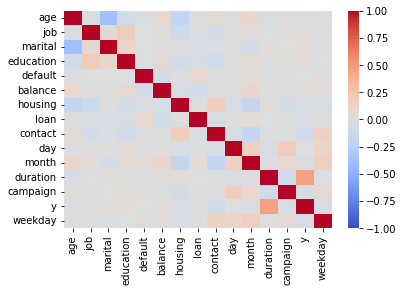

In [9]:
# Build a heatmap of correlation of values in dataset
sns.heatmap(df.corr(), cmap = 'coolwarm', vmin = -1, vmax = 1)

Heatmap indicates that there is a coorelation between result of sale and duration of call. I have found out this correlation earlier using boxplot. This data will be dropped from dataset as it is useless for prediction of success of sale. I also think that campaign feature is not as important as other features and should be dropped.

In [10]:
# Drop extra columns and separate data to features and target
X = df.drop(['y','duration', 'campaign', 'weekday'], axis = 1)
y = df['y']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [11]:
# Count result labels to check how balanced dataset is
print(f' Ratio of positive results to all results in whole dataset: {df.y.sum()/df.shape[0]}')
print(f' Ratio of positive results to all results in training set: {y_train.sum()/y_train.shape[0]}')
print(f' Ratio of positive results to all results in test set: {y_test.sum()/y_test.shape[0]}')

 Ratio of positive results to all results in whole dataset: 0.0724
 Ratio of positive results to all results in training set: 0.0725
 Ratio of positive results to all results in test set: 0.072


There are much more negative results from calls than positive ones. So our dataset is very imbalanced, with 7% of data is negative and 93% is positive. It means that if our model will keep giving negative result to all cases, it will be right 93% of a time. Representativeness of train and test sets were checked.   
Also due to this imbalance, balanced accuracy is by far better threshold for our model.

Next step is scaling the data:

In [12]:
# Scale X_train and X_test arrays using StandardScaler 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Testing different models to find best performer

Next step is to find choose the classification model that has best balanced accuracy for the given dataset. Multiple classification models are choosen to perform this assessment: KNN, logistic regression, random forest, XBG, etc. I wrote a function to automate this task and print results.

In [13]:
# List all the models I am planning to test
models = [KNeighborsClassifier, LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, 
          ExtraTreeClassifier, BaggingClassifier, XGBClassifier, LGBMClassifier]

# Function to assess models
def run_classifier(models):
    acc = []
    bal_acc = []
    roc_auc = []
    precision_yes = []
    precision_no = []
    recall_yes = []
    recall_no = []
    
    # Loop to go through models
    for model in models:
        # Create classifier and fit to dataset
        clf = model()
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        acc.append(accuracy_score(y_test, y_pred))
        bal_acc.append(balanced_accuracy_score(y_test, y_pred))
        precision_yes.append(precision_score(y_test,y_pred, pos_label = 1))
        precision_no.append(precision_score(y_test,y_pred, pos_label = 0))
        recall_yes.append(recall_score(y_test,y_pred, pos_label = 1))
        recall_no.append(recall_score(y_test,y_pred, pos_label = 0))

        y_pred_prob = clf.predict_proba(X_test)[:,1]
        roc_auc.append(roc_auc_score(y_test, y_pred_prob))

    d = {'accuracy':acc, 'balanced_accuracy':bal_acc, 'precision_yes':precision_yes, 'precision_no':precision_no, 'recall_yes':recall_yes, 'recall_no':recall_no, 'roc_auc':roc_auc}
    df_mods = pd.DataFrame(d, index = map(str, models)).round(3)
    return(df_mods)

In [14]:
# Run the function to assess models
results_df = run_classifier(models)
results_df.head(10)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:40:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,accuracy,balanced_accuracy,precision_yes,precision_no,recall_yes,recall_no,roc_auc
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>,0.924,0.520,0.315,0.931,0.049,0.992,0.599
<class 'sklearn.linear_model._logistic.LogisticRegression'>,0.928,0.500,0.000,0.928,0.000,1.000,0.626
<class 'sklearn.ensemble._forest.RandomForestClassifier'>,0.927,0.525,0.444,0.931,0.056,0.995,0.680
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>,0.928,0.523,0.492,0.931,0.050,0.996,0.706
<class 'sklearn.tree._classes.ExtraTreeClassifier'>,0.878,0.545,0.155,0.935,0.156,0.934,0.545
<class 'sklearn.ensemble._bagging.BaggingClassifier'>,0.922,0.538,0.345,0.933,0.089,0.987,0.639
<class 'xgboost.sklearn.XGBClassifier'>,0.929,0.548,0.532,0.934,0.102,0.993,0.683
<class 'lightgbm.sklearn.LGBMClassifier'>,0.930,0.536,0.587,0.933,0.076,0.996,0.712


As expected all of models give accuracy of ~93% and balanced accuracy is at ~50%. Which is low, as if model would keep predicting "failure" it will be right 93% of the time. Logistic regression is that case, as it has accuracy of 92.8% and 0 precision in cases of success in sales.  
Next I decided to check how different are results if I evaluate model with 5-fold cross validation and report the average performance score.

In [15]:
X_scaled = scaler.fit_transform(X)
X_shuffle, y_shuffle = shuffle(X_scaled, y, random_state=42)

# Loop to go through models
for model in models:
    # Create classifier and fit to dataset
    clf = model()
    scores = cross_val_score(clf, X_shuffle, y_shuffle, scoring="balanced_accuracy", cv=5, n_jobs=-1)
    model_name = str(model).split(".")[-1][:-2]
    print(f"Average balanced accuracy of {model_name} is {round(np.mean(scores), 3)}")

Average balanced accuracy of KNeighborsClassifier is 0.525
Average balanced accuracy of LogisticRegression is 0.5
Average balanced accuracy of RandomForestClassifier is 0.528
Average balanced accuracy of GradientBoostingClassifier is 0.527
Average balanced accuracy of ExtraTreeClassifier is 0.547
Average balanced accuracy of BaggingClassifier is 0.543
Average balanced accuracy of XGBClassifier is 0.545
Average balanced accuracy of LGBMClassifier is 0.531


Average balanced accuracies are not different from the ones obrained from regular tests. So I decided To proceed with regular tests as I can collect other metrics this way.

## Sorted labeling approach
In this part of the project I approach label encoding through smarter labeling of the categorical data. EDA is used to properly identify and sort labels into numerical values. As well as grouping categories into broader labels

In [16]:
# Start by loading data
df = pd.read_csv('datasets/term-deposit-marketing-2020.csv')

# Print all the unique values of categorical data columns 
chk_categoricals(df).head(20)

,0,1,2,3,4,5,6,7,8,9,10,11
job,management,technician,entrepreneur,blue-collar,unknown,retired,admin,services,self-employed,unemployed,housemaid,student
marital,married,single,divorced,None,None,None,None,None,None,None,None,None
education,tertiary,secondary,unknown,primary,None,None,None,None,None,None,None,None
default,no,yes,None,None,None,None,None,None,None,None,None,None
housing,yes,no,None,None,None,None,None,None,None,None,None,None
loan,no,yes,None,None,None,None,None,None,None,None,None,None
contact,unknown,cellular,telephone,None,None,None,None,None,None,None,None,None
month,may,jun,jul,aug,oct,nov,dec,jan,feb,mar,apr,None
y,no,yes,None,None,None,None,None,None,None,None,None,None


First work on yes/no variables, as they are easily replaced by 0 and 1. These columns are:
- y
- loan
- housing
- default

In [17]:
# Columns with yes/no values
cols = ['y', 'loan', 'housing', 'default']

# Replacing yes/no values to 1/0 numerical values
for col in cols:
    df[col].replace({'yes':1,'no':0}, inplace = True)

Now it is time to replace months with numerical representation. There are two ways for me to convert them. It is either to convert to 12 months or to four seasons. I think there is not much difference in either way I choose.   
Also education category is changed to numerical, by order from lowest to highest. Median education level in Europe is slightly lower than secondary. Then it make sense to sort them by education level starting from lowest to highest. Primary education being 0, and tertiary is 3.

In [18]:
# Create dictionary with months values. Replacement of month column data
d_m = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
df['month'].replace(d_m, inplace = True)

# Create dictionary with education values
d_ed = {'primary':0, 'unknown':1, 'secondary':2, 'tertiary':3}
df['education'].replace(d_ed,inplace = True)

# Recheck of leftover categorical data columns
chk_categoricals(df).head(20)

,0,1,2,3,4,5,6,7,8,9,10,11
job,management,technician,entrepreneur,blue-collar,unknown,retired,admin,services,self-employed,unemployed,housemaid,student
marital,married,single,divorced,None,None,None,None,None,None,None,None,None
contact,unknown,cellular,telephone,None,None,None,None,None,None,None,None,None


Deeper EDA is should be performed to properly label the rest of the columns. Jobs could be encoded by their median income levels, as income plays crucial role in willingness to purchase our service. Another way is to group this categories based on the their success rates. To do it I need to know each job's success rates.

In [19]:
# Get all unique values in "job" columns
jobs = df['job'].unique()

# Go through each specialty and count successes and failures. Record their ratios using normalize parameter
l = []
for job in jobs:
    l.append(df[df['job']== job]['y'].value_counts(normalize = True))

# Put data in dataframe
jobs_df = pd.DataFrame(l, index = jobs).round(4)
jobs_df.sort_values(by=0).head(15)

,0,1
student,0.8435,0.1565
retired,0.8949,0.1051
unemployed,0.9130,0.0870
management,0.9172,0.0828
self-employed,0.9208,0.0792
admin,0.9217,0.0783
technician,0.9275,0.0725
unknown,0.9277,0.0723
entrepreneur,0.9374,0.0626
services,0.9391,0.0609


We know that average success rate for all professions is 0.9276. And it is clear that some professions have higher rates of success, while others are lower. To have a better idea on each category, I visualize this data into bar chart

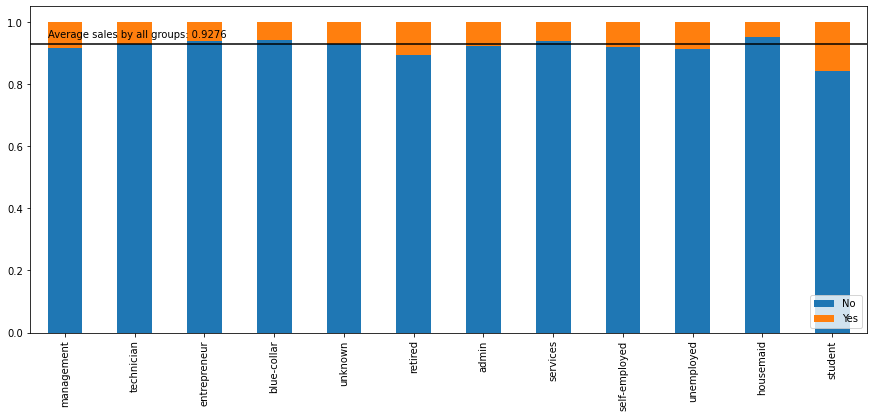

In [20]:
# Plot stacked bar chart 
jobs_df.plot(kind = 'bar', stacked = True, figsize = [15,6])

# Add legend
plt.legend(labels = ['No', 'Yes'],loc = 4)

# Draw horizontal line for average overall success rate
y_dist = df['y'].value_counts()
y_line = y_dist[0]/y_dist.sum()
plt.axhline(y=y_line, color = 'k')
plt.text(x = -0.25, y = 0.95, s = f'Average sales by all groups: {y_line}')

plt.show()

From the chart it is clear that some categories of jobs have higher success rates than others. For example, students tend to have much higher sale rate (84.35%) compared to average (92.76%). It can be due to lower number of students in mass, however it is a good measure to sort labels. Values are sorted in following order:
- housemaid
- blue-collar
- services
- entrepreneur
- unknown
- technician
- admin
- self-employed
- management
- unemployed
- retired
- student

In [21]:
# Create dictionary with jobs values
d_jobs = {'housemaid':0, 
          'blue-collar':1, 
          'services':2, 
          'entrepreneur':3, 
          'unknown':4,
          'technician':5,
          'admin':6, 
          'self-employed':7,
          'management':8,
          'unemployed':9, 
          'retired':10,
          'student':11}

# Replace values in education column
df['job'].replace(d_jobs,inplace = True)

Now it is necessary to perform the same operation with marital status to understand how it affects success rate. There are only three categories: married, single and divorced. And it is important to see how marital status affects result. 

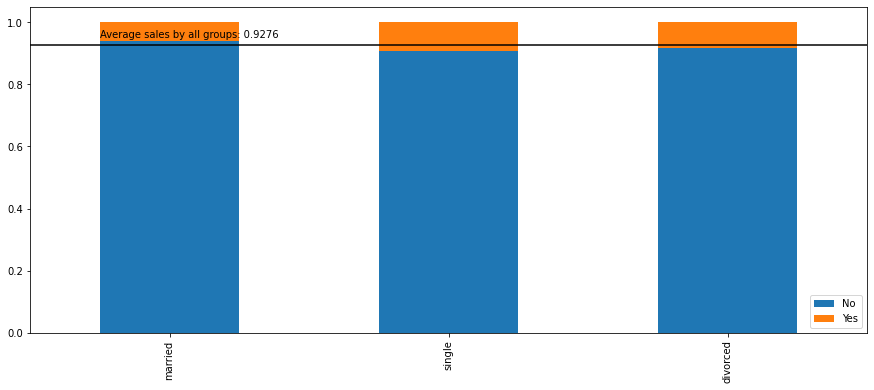

married     24386
single      10889
divorced     4725
Name: marital, dtype: int64


,0,1
married,0.939391,0.060609
single,0.905685,0.094315
divorced,0.917249,0.082751


In [22]:
# Get all unique values in "marital" columns
marital = df['marital'].unique()

# Go through each marital status and count successes and failures. Record their ratios using normalize parameter
l = []
for status in marital:
    l.append(df[df['marital']== status]['y'].value_counts(normalize = True))

# Put data in dataframe
status_df = pd.DataFrame(l, index = marital)

# Plot stacked bar chart 
status_df.plot(kind = 'bar', stacked = True, figsize = [15,6])

# Add legend
plt.legend(labels = ['No', 'Yes'],loc = 4)

# Draw horizontal line for average overall success rate
y_dist = df['y'].value_counts()
y_line = y_dist[0]/y_dist.sum()
plt.axhline(y=y_line, color = 'k')
plt.text(x = -0.25, y = 0.95, s = f'Average sales by all groups: {y_line}')
plt.show()

# Print number of entries in each category and ratios of success and failure
print(df['marital'].value_counts())
status_df.head()

From the plot above, it is clear that success among single and dicorced groups is higher than average. So marital status clearly has an effect on the result. However there is no point of putting divorced and single in one group as their success rates are different by 1.2%. Categories will be sorted in following order: married, divorced, single.

In [23]:
# Create dictionary with marital values
d_marital = {'married':0, 
             'divorced':1, 
             'single':2}

# Replace values in education column
df['marital'].replace(d_marital,inplace = True)

The last feature to consider is "contacts". The same operation is performed here.

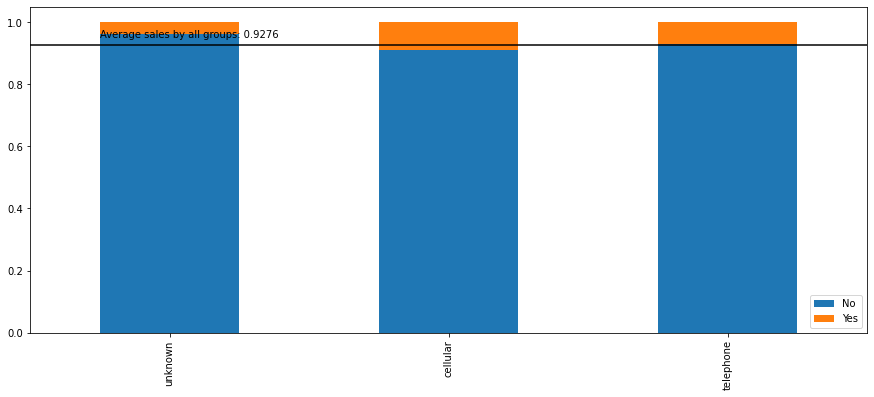

cellular     24914
unknown      12765
telephone     2321
Name: contact, dtype: int64


,0,1
unknown,0.961065,0.038935
cellular,0.910372,0.089628
telephone,0.928479,0.071521


In [24]:
# Get all unique values in "contact" column
contacts = df['contact'].unique()

# Go through each type of contact and count successes and failures. Record their ratios using normalize parameter
l = []
for contact in contacts:
    l.append(df[df['contact']== contact]['y'].value_counts(normalize = True))

# Put data in dataframe
contact_df = pd.DataFrame(l, index = contacts)

# Plot stacked bar chart 
contact_df.plot(kind = 'bar', stacked = True, figsize = [15,6])

# Add legend
plt.legend(labels = ['No', 'Yes'],loc = 4)

# Draw horizontal line for average overall success rate
y_dist = df['y'].value_counts()
y_line = y_dist[0]/y_dist.sum()
plt.axhline(y=y_line, color = 'k')
plt.text(x = -0.25, y = 0.95, s = f'Average sales by all groups: {y_line}')
plt.show()

# Print number of entries in each category and ratios of success and failure
print(df['contact'].value_counts())
contact_df.head()

From the plot above, it is clear that success rate among cellular phone number group is higher than average. While for unknown phone types success rate is lower than average. So, categories will be sorted in following order: unknown, telephone, cellular.

In [25]:
# Create dictionary with contact type values
d_contact = {'unknown':0, 
             'telephone':1, 
             'cellular':2}

# Replace values in education column
df['contact'].replace(d_contact,inplace = True)

Since the dataset is ready, it is time to separate data to target and features. And split dataset to training and test sets.

In [26]:
# Drop extra columns and separate data to features and target
X = df.drop(['y','duration', 'campaign'], axis = 1)
y = df['y']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Next step is scaling the data:

In [27]:
# Scale X_train and X_test arrays using StandardScaler 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Testing different models to find best performer
Next step is to find choose the classification model that has best balanced accuracy for the given dataset. Multiple classification models are choosen to perform this assessment: KNN, logistic regression, random forest, XBG, etc. I wrote a function to automate this task and print results.

In [28]:
# Run the function to assess models
results_df = run_classifier(models)
results_df.head(10)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,accuracy,balanced_accuracy,precision_yes,precision_no,recall_yes,recall_no,roc_auc
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>,0.925,0.524,0.356,0.931,0.056,0.992,0.599
<class 'sklearn.linear_model._logistic.LogisticRegression'>,0.928,0.500,0.000,0.928,0.000,1.000,0.640
<class 'sklearn.ensemble._forest.RandomForestClassifier'>,0.927,0.526,0.429,0.931,0.057,0.994,0.690
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>,0.928,0.519,0.480,0.931,0.042,0.996,0.708
<class 'sklearn.tree._classes.ExtraTreeClassifier'>,0.877,0.550,0.162,0.935,0.168,0.932,0.550
<class 'sklearn.ensemble._bagging.BaggingClassifier'>,0.923,0.542,0.373,0.934,0.097,0.987,0.646
<class 'xgboost.sklearn.XGBClassifier'>,0.928,0.546,0.500,0.934,0.101,0.992,0.696
<class 'lightgbm.sklearn.LGBMClassifier'>,0.928,0.530,0.493,0.932,0.064,0.995,0.720


From results of model runs, it can be noticed that there is no improvement in classifier performances from performing "smart" labeling. So, the following step is application of one hot labeling.
## One hot method

In [29]:
# Start by loading data
df = pd.read_csv('datasets/term-deposit-marketing-2020.csv')

First work on yes/no variables, as they are easily replaced by 0 and 1.

In [30]:
# Columns with yes/no values
cols = ['y', 'loan', 'housing', 'default']

# Replacing yes/no values to 1/0 numerical values
for col in cols:
    df[col].replace({'yes':1,'no':0}, inplace = True)

The rest of features will be converted to numerical using one hot method

In [31]:
df = pd.get_dummies(df, columns = ['job', 'marital', 'education', 'contact','month'])
df.head()

,age,default,balance,housing,loan,day,duration,campaign,y,job_admin,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,0,2143,1,0,5,261,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,44,0,29,1,0,5,151,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,33,0,2,1,1,5,76,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,47,0,1506,1,0,5,92,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,33,0,1,0,0,5,198,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [32]:
# Drop extra columns and separate data to features and target
X = df.drop(['y','duration', 'campaign'], axis = 1)
y = df['y']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [33]:
# Scale X_train and X_test arrays using StandardScaler 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
# Run the function to assess models
results_df = run_classifier(models)
results_df.head(10)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:43:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,accuracy,balanced_accuracy,precision_yes,precision_no,recall_yes,recall_no,roc_auc
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>,0.926,0.539,0.418,0.933,0.089,0.990,0.609
<class 'sklearn.linear_model._logistic.LogisticRegression'>,0.928,0.514,0.531,0.930,0.030,0.998,0.683
<class 'sklearn.ensemble._forest.RandomForestClassifier'>,0.927,0.537,0.470,0.933,0.082,0.993,0.687
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>,0.929,0.533,0.562,0.933,0.071,0.996,0.712
<class 'sklearn.tree._classes.ExtraTreeClassifier'>,0.878,0.548,0.160,0.935,0.163,0.933,0.548
<class 'sklearn.ensemble._bagging.BaggingClassifier'>,0.923,0.541,0.370,0.934,0.094,0.988,0.632
<class 'xgboost.sklearn.XGBClassifier'>,0.929,0.544,0.535,0.934,0.094,0.994,0.707
<class 'lightgbm.sklearn.LGBMClassifier'>,0.930,0.535,0.597,0.933,0.075,0.996,0.719


Balanced accuracy has not increased using the one hot method. So, labeling method does not have much of the effect on the performance of classifiers in this project. Now I need to find out which parameters are the most important in this classification.

### Finding features importances

In this part of the project I will try to find how important each feature is. Also I will try to figure out how classifiers use features.  
Firstly, I need to bring dataframe to the 'sorted' label encoding mode. As in one hot mode there are too many columns and it will be difficult to differentiate which features are important.


In [35]:
# Start by loading data
df = pd.read_csv('datasets/term-deposit-marketing-2020.csv')

# Columns with yes/no values
cols = ['y', 'loan', 'housing', 'default']

# Replacing yes/no values to 1/0 numerical values
for col in cols:
    df[col].replace({'yes':1,'no':0}, inplace = True)

# Create dictionary with months values. Replacement of month column data
d_m = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
df['month'].replace(d_m, inplace = True)

# Create dictionary with education values
d_ed = {'primary':0, 'unknown':1, 'secondary':2, 'tertiary':3}
df['education'].replace(d_ed,inplace = True)

# Create dictionary with jobs values
d_jobs = {'housemaid':0, 
          'blue-collar':1, 
          'services':2, 
          'entrepreneur':3, 
          'unknown':4,
          'technician':5,
          'admin':6, 
          'self-employed':7,
          'management':8,
          'unemployed':9, 
          'retired':10,
          'student':11}

# Replace values in education column
df['job'].replace(d_jobs,inplace = True)

# Create dictionary with marital values
d_marital = {'married':0, 
             'divorced':1, 
             'single':2}

# Replace values in education column
df['marital'].replace(d_marital,inplace = True)

# Create dictionary with contact type values
d_contact = {'unknown':0, 
             'telephone':1, 
             'cellular':2}

# Replace values in education column
df['contact'].replace(d_contact,inplace = True)

# Drop extra columns and separate data to features and target
X = df.drop(['y','duration', 'campaign'], axis = 1)
y = df['y']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Scale X_train and X_test arrays using StandardScaler 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

XGBoost classifier is decent in prediction, so I will work on this model.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:43:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score: 0.928
Balanced accuracy score: 0.546

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      7424
           1       0.50      0.10      0.17       576

    accuracy                           0.93      8000
   macro avg       0.72      0.55      0.57      8000
weighted avg       0.90      0.93      0.91      8000



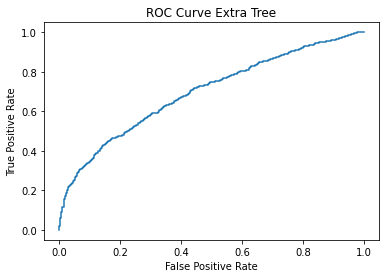

AUC score: 0.696



In [36]:
# Create XGBoost classifier with default parameters
clf = XGBClassifier()

# Fit model to the train set
clf.fit(X_train, y_train)

# Predict values from the test set
y_pred = clf.predict(X_test)

# Accuracy score and classification report of the model
print('Accuracy score: {}'.format(round(accuracy_score(y_test, y_pred),3)))
print('Balanced accuracy score: {}\n'.format(round(balanced_accuracy_score(y_test, y_pred),3)))

print('Classification report:\n',classification_report(y_test, y_pred))

# Build ROC curve
y_pred_prob = clf.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label = 'Extra Tree')
plt.title('ROC Curve Extra Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# get AUC score
print('AUC score: {}\n'.format(round(roc_auc_score(y_test, y_pred_prob),3)))

In [37]:
# print(clf.feature_importances_)
fi_df = pd.DataFrame(clf.feature_importances_, index = X.columns, columns = ['Feature Importance']).sort_values(by = 'Feature Importance',ascending=False)
fi_df

,Feature Importance
month,0.168833
contact,0.157889
housing,0.155151
day,0.095564
marital,0.066917
balance,0.065649
loan,0.061122
job,0.060983
age,0.060715
education,0.059239


So, surprisingly, the most important features are month, contact, housing and day. While features like age, education or job that might seem important, are among least important features. It is a very unexpected finding, and to investigate it further another model is checked.  
LGBM Classifier is also a gradient boosting classifier. It is chosen as it has higher accuracy on preicting sales among others.

Accuracy score: 0.928
Balanced accuracy score: 0.53

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      7424
           1       0.49      0.06      0.11       576

    accuracy                           0.93      8000
   macro avg       0.71      0.53      0.54      8000
weighted avg       0.90      0.93      0.90      8000



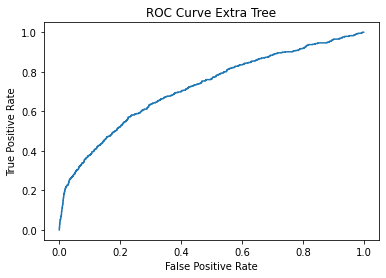

AUC score: 0.72



In [38]:
# Create LGBMClassifier classifier with default parameters
clf = LGBMClassifier()

# Fit model to the train set
clf.fit(X_train, y_train)

# Predict values from the test set
y_pred = clf.predict(X_test)

# Accuracy score and classification report of the model
print('Accuracy score: {}'.format(round(accuracy_score(y_test, y_pred),3)))
print('Balanced accuracy score: {}\n'.format(round(balanced_accuracy_score(y_test, y_pred),3)))

print('Classification report:\n',classification_report(y_test, y_pred))

# Build ROC curve
y_pred_prob = clf.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label = 'Extra Tree')
plt.title('ROC Curve Extra Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# get AUC score
print('AUC score: {}\n'.format(round(roc_auc_score(y_test, y_pred_prob),3)))

In [39]:
# print(clf.feature_importances_)
fi_df = pd.DataFrame(clf.feature_importances_, index = X.columns, columns = ['Feature Importance']).sort_values(by = 'Feature Importance',ascending=False)
fi_df

,Feature Importance
balance,851
age,571
day,548
month,306
job,253
education,129
contact,102
marital,97
housing,67
loan,64


Here feature importances differ from the previous model. Top features are balance, age, day, month and job. Again, day and month are among most important features. However now ther is also average account balance, age of the customer and profession of the customer. It makes more sense to predict success based on these parameters. Now I will try to get top features from two models above and run a classifier based only on most important parameters. Most important parameters are:
- balance
- month
- age
- contact
- day
- housing
- job
- marital

In [40]:
# Drop extra columns and separate data to features and target
X = df.drop(['y','duration', 'campaign', 'default','loan','education'], axis = 1)
y = df['y']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [41]:
results_df = run_classifier(models)
results_df.head(10)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: Us

[17:43:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,accuracy,balanced_accuracy,precision_yes,precision_no,recall_yes,recall_no,roc_auc
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>,0.924,0.500,0.086,0.928,0.005,0.996,0.530
<class 'sklearn.linear_model._logistic.LogisticRegression'>,0.928,0.500,0.000,0.928,0.000,1.000,0.609
<class 'sklearn.ensemble._forest.RandomForestClassifier'>,0.928,0.535,0.506,0.933,0.076,0.994,0.684
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>,0.929,0.524,0.556,0.931,0.052,0.997,0.704
<class 'sklearn.tree._classes.ExtraTreeClassifier'>,0.882,0.543,0.158,0.934,0.148,0.939,0.543
<class 'sklearn.ensemble._bagging.BaggingClassifier'>,0.925,0.541,0.402,0.934,0.092,0.989,0.640
<class 'xgboost.sklearn.XGBClassifier'>,0.927,0.540,0.472,0.933,0.087,0.992,0.690
<class 'lightgbm.sklearn.LGBMClassifier'>,0.928,0.524,0.526,0.931,0.052,0.996,0.714


## Conclusion

Having less parameters did not decrease my accuracy, so I settled on these features. Any gradient boosting model can be used for the purpose of prediction of sale success. Also some parameters like job, contact type or education level proved to be important features in predicting if customer can be successful sale.

In this work I tried different techniques of treating categorical data. However due to the character of data we have, there were no much of the difference in accuracy of the model. However I would assume that one hot method would give best results as it does not give labels that differ much as in other cases. Example can be month where January should not be much of a different than December, however for our data it is 1 and 12. The dataset we got was highly inbalanced, with 93% of data is for failure cases. It means that if the model is very bias and predicts 0 all the time, it will be right 92% of times. Hence will have accuracy of 93%.

Results of simulations indicated that the most important features were: balance on account, month, age of customer, type of the contact, day, housing loan, type of job and marital status. Balance on account is very important parameter as our service requires customers to have money to use our savings account. Month and date features are among important ones. It matters when to make a call as people tend to make this kind of decisions early in a year or end of it. As well as early dates of a month when they get salaries. Also age is an important feature in this case. 

From EDA it was found that categorical features like job, type of contact and marital status can be good predictors of success of sale. There is a clear tendency for success with students and retired people. Also if the customer has cell phone, it is more likely to sell the product. Or the marital status analyses indicate that single people are more likely to subscribe to our product. Also EDA that I performed indicated that there is no point of making campaign calls to the client if there were over 30 calls before. There are no cases of successful turns in this case. One more finding of this project was the fact that it does not matter which day of the week the call is made. Success rate is same in any day of week. 